# Group 1: Capstone Project - Forecasting State-Wise Crop Yield in India

## Objective :

Build a regression model to forecast the future cropyield for major crops like rice, wheat, sugarcane, andmaize across Indian states. 
Using historical data on crop yield, area, and production from the Crop Yield in Indian States dataset, the model will predict future yields to inform agricultural planning and policy decisions. The system will be trained using models such as Linear Regression, XGBoost, and LSTM.

### Key Points:

✔ Supports agricultural planning

✔ Helps policymakers allocate resources

✔ Identifies yield trends and variability

✔ Improves food security and farmer planning



## Datasets used here :

1. Crop_recommendation.csv : https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset
2. crop_yield_statewise.csv : https://www.kaggle.com/datasets/akshatgupta7/crop-yield-in-indian-states-dataset


### ➨ Dataset 1 → Crop_recommendation.csv 

a) Crop_recommendation.csv (Soil & Weather Dataset)
Contains soil nutrients and weather data:
1. Soil nutrients: `N`, `P`, `K`, `ph`
2. Weather conditions: `temperature`, `humidity`, `rainfall`
3. Target label: `label` (crop name suitable for those conditions)

### ➨ Dataset 2 → crop_yield_statewise.csv 

b) crop_yield_statewise.csv (Production Dataset)
Contains state-wise agricultural data:
1. Identifiers: `Crop`, `Crop_Year`, `Season`, `State`
2. Production info: `Area`, `Production`, `Yield`
3. Inputs: `Fertilizer`, `Pesticide`
4. Climate data: `Annual_Rainfall`


### ➨ Logic Behind Combining These Two Datasets

The goal was to enrich the yield dataset (which already has crop, state, year, season, area, production, yield, fertilizer, pesticide) with environmental and soil conditions from the recommendation dataset.

#### ➨ Here’s the reasoning step-by-step:

1. Identify common key columns
    1. Both datasets contain a crop column → this is the natural join key.
    2. crop_yield_statewise has state, year, season → but soil dataset doesn’t.
    3. So the only direct link was crop.
2. Align soil-weather data with crop yields
    1. For each crop in crop_yield_statewise, the average environmental conditions (avg_temp_c, total_rainfall_mm, avg_humidity_percent, N,  P, K, pH) were pulled from Crop_recommendation.
    2. If there were multiple records per crop in Crop_recommendation, most likely the script took mean/representative values.

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Understanding and Preprocessing the data 

In [253]:
df = pd.read_csv("combined_crop_soil_weather.csv")

In [255]:
df.shape

(19689, 16)

In [257]:
df.columns.tolist()

['crop',
 'year',
 'season',
 'state',
 'area',
 'production',
 'fertilizer',
 'pesticide',
 'yield',
 'avg_temp_c',
 'total_rainfall_mm',
 'avg_humidity_percent',
 'N',
 'P',
 'K',
 'pH']

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crop                  19689 non-null  object 
 1   year                  19689 non-null  int64  
 2   season                19689 non-null  object 
 3   state                 19689 non-null  object 
 4   area                  19689 non-null  float64
 5   production            19689 non-null  int64  
 6   fertilizer            19689 non-null  float64
 7   pesticide             19689 non-null  float64
 8   yield                 19689 non-null  float64
 9   avg_temp_c            19689 non-null  float64
 10  total_rainfall_mm     19689 non-null  float64
 11  avg_humidity_percent  19689 non-null  float64
 12  N                     19689 non-null  int64  
 13  P                     19689 non-null  int64  
 14  K                     19689 non-null  int64  
 15  pH                 

In [261]:
# Change year column to object (categorical)
df['year'] = df['year'].astype(object)   # or .astype('object')

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crop                  19689 non-null  object 
 1   year                  19689 non-null  object 
 2   season                19689 non-null  object 
 3   state                 19689 non-null  object 
 4   area                  19689 non-null  float64
 5   production            19689 non-null  int64  
 6   fertilizer            19689 non-null  float64
 7   pesticide             19689 non-null  float64
 8   yield                 19689 non-null  float64
 9   avg_temp_c            19689 non-null  float64
 10  total_rainfall_mm     19689 non-null  float64
 11  avg_humidity_percent  19689 non-null  float64
 12  N                     19689 non-null  int64  
 13  P                     19689 non-null  int64  
 14  K                     19689 non-null  int64  
 15  pH                 

In [265]:
df.describe()

,area,production,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,N,P,K,pH
count,1.968900e+04,1.968900e+04,1.968900e+04,1.968900e+04,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000
mean,1.799266e+05,1.643594e+07,2.410331e+07,4.884835e+04,79.954009,24.008025,1337.999356,64.676018,76.626847,33.499264,32.234547,6.640292
std,7.328287e+05,2.630568e+08,9.494600e+07,2.132874e+05,878.306193,4.408018,637.585197,11.474130,20.060556,11.556686,7.915514,0.690622
min,5.000000e-01,0.000000e+00,5.417000e+01,9.000000e-02,0.000000,6.260000,249.240000,34.470000,50.000000,15.000000,20.000000,5.500000
25%,1.390000e+03,1.393000e+03,1.880146e+05,3.567000e+02,0.600000,22.910000,894.160000,54.620000,65.000000,24.000000,25.000000,6.000000
50%,9.317000e+03,1.380400e+04,1.234957e+06,2.421900e+03,1.030000,25.560000,1172.020000,68.110000,72.000000,38.000000,33.000000,6.600000
75%,7.511200e+04,1.227180e+05,1.000385e+07,2.004170e+04,2.388889,26.810000,1613.400000,73.730000,80.000000,43.000000,38.000000,7.100000
max,5.080810e+07,6.326000e+09,4.835407e+09,1.575051e+07,21105.000000,28.630000,5244.360000,86.060000,150.000000,55.000000,50.000000,8.000000


In [267]:
df.head(10)

,crop,year,season,state,area,production,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,N,P,K,pH
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,7024878.38,22882.34,0.796087,22.41,1468.92,70.71,60,18,38,5.8
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,631643.29,2057.47,0.710435,22.41,1468.92,70.71,60,18,38,5.8
2,Castor seed,1997,Kharif,Assam,796.0,22,75755.32,246.76,0.238333,22.41,1468.92,70.71,60,18,38,5.8
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,1870661.52,6093.36,5238.051739,22.41,1468.92,70.71,60,18,38,5.8
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,165500.63,539.09,0.420909,22.41,1468.92,70.71,60,18,38,5.8
5,Dry chillies,1997,Whole Year,Assam,13587.0,9073,1293074.79,4211.97,0.643636,22.41,1468.92,70.71,60,18,38,5.8
6,Gram,1997,Rabi,Assam,2979.0,1507,283511.43,923.49,0.465455,22.41,1468.92,70.71,60,18,38,5.8
7,Jute,1997,Kharif,Assam,94520.0,904095,8995468.40,29301.20,9.919565,22.41,1468.92,70.71,60,18,38,5.8
8,Linseed,1997,Rabi,Assam,10098.0,5158,961026.66,3130.38,0.461364,22.41,1468.92,70.71,60,18,38,5.8
9,Maize,1997,Kharif,Assam,19216.0,14721,1828786.72,5956.96,0.615652,22.41,1468.92,70.71,60,18,38,5.8


In [269]:
# Check missing values
df.isnull().sum()

crop                    0
year                    0
season                  0
state                   0
area                    0
production              0
fertilizer              0
pesticide               0
yield                   0
avg_temp_c              0
total_rainfall_mm       0
avg_humidity_percent    0
N                       0
P                       0
K                       0
pH                      0
dtype: int64

In [271]:
# Check duplicates
df.duplicated().sum()

0

In [273]:
# Check for Numerical columns
df.select_dtypes(include=['number']).columns.tolist()

['area',
 'production',
 'fertilizer',
 'pesticide',
 'yield',
 'avg_temp_c',
 'total_rainfall_mm',
 'avg_humidity_percent',
 'N',
 'P',
 'K',
 'pH']

In [275]:
# Check for Categorical columns
df.select_dtypes(include=['object']).columns.tolist()

['crop', 'year', 'season', 'state']

In [279]:
# Check categorical unique values
print("\nTotal Unique years:", df['year'].nunique())
print("\n", df['year'].unique())
print("\nTotal Unique crops:", df['crop'].nunique())
print("\n", df['crop'].unique())
print("\nTotal Unique states:", df['state'].nunique())
print("\n", df['state'].unique())
print("\nTotal Unique season:", df['season'].nunique())
print("\n", df['season'].unique())


Total Unique years: 24

 [1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]

Total Unique crops: 55

 ['Arecanut' 'Arhar/Tur' 'Castor seed' 'Coconut ' 'Cotton(lint)'
 'Dry chillies' 'Gram' 'Jute' 'Linseed' 'Maize' 'Mesta' 'Niger seed'
 'Onion' 'Other  Rabi pulses' 'Potato' 'Rapeseed &Mustard' 'Rice'
 'Sesamum' 'Small millets' 'Sugarcane' 'Sweet potato' 'Tapioca' 'Tobacco'
 'Turmeric' 'Wheat' 'Bajra' 'Black pepper' 'Cardamom' 'Coriander' 'Garlic'
 'Ginger' 'Groundnut' 'Horse-gram' 'Jowar' 'Ragi' 'Cashewnut' 'Banana'
 'Soyabean' 'Barley' 'Khesari' 'Masoor' 'Moong(Green Gram)'
 'Other Kharif pulses' 'Safflower' 'Sannhamp' 'Sunflower' 'Urad'
 'Peas & beans (Pulses)' 'other oilseeds' 'Other Cereals' 'Cowpea(Lobia)'
 'Oilseeds total' 'Guar seed' 'Other Summer Pulses' 'Moth']

Total Unique states: 30

 ['Assam' 'Karnataka' 'Kerala' 'Meghalaya' 'West Bengal' 'Puducherry' 'Goa'
 'Andhra Pradesh' 'Tamil Nadu' 'Odisha' 'Biha

### 1. Dataset Overview
- Rows: 19,689
- Columns: 16
- Types:
    - Categorical: crop, season, state, year
    - Numerical: area, production, fertilizer, pesticide, yield, avg_temp_c, total_rainfall_mm, avg_humidity_percent, N, P, K, pH

### 2. Missing / Null Values
1. No missing values detected — all columns are complete.

### 3. Categorical Variables
1. crop → crop name (string)
2. season → cropping season (e.g., Kharif, Rabi, Whole Year)
3. state → Indian states/regions
4. year → yeild year  (ranging from ~1997 onward)
5. Cleaning to apply:
    1. Standardize text (remove trailing spaces, unify case, handle alternate spellings).
    2. Encode categories if needed (Label Encoding / One-Hot Encoding for ML models).

### 4. Numerical Variables
1. area, production, fertilizer, pesticide, yield → Continuous values
2. avg_temp_c, total_rainfall_mm, avg_humidity_percent → Climate variables
3. N, P, K, pH → Soil attributes
4. Cleaning to apply:
    1. Check for outliers (e.g., abnormally high production values or negative values).
    2. Convert year into datetime index if doing time-series analysis.
    3. Normalize/scale variables for ML (e.g., MinMaxScaler or StandardScaler).

### 5. Data Cleaning Steps Applied / Recommended
1. Verified no null/missing values.
2. Identify outliers in area, production, fertilizer, pesticide, yield.
3.  Standardize categorical strings (crop, season, state, year).


📌 Column: area
Outliers detected: 3076
Sample outliers:
           area
15     279292.0
16     607358.0
18    1743321.0
28     421810.0
29     301149.0
34     186579.0
38     847666.0
39     192416.0
42     389690.0
43    1501172.0
45     502797.0
48     897921.0
51    1031530.0
53     268044.0
54     308857.0
56     250698.0
60     884344.0
101    641574.0
110  50808100.0
113    284015.0


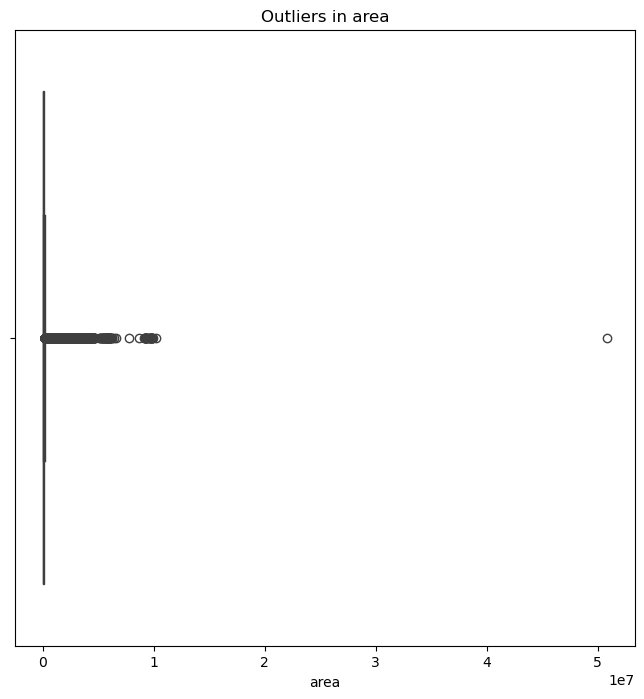


📌 Column: production
Outliers detected: 3373
Sample outliers:
     production
3     126905000
7        904095
14       671871
16       398311
18      1647296
21      1287451
38       525562
42       516093
43       722773
45      1391132
48      1214282
51      2340493
53       762759
54     28999269
60   5210000000
61      2841819
94    306202300
101     7549700
110    38657300
113     5581553


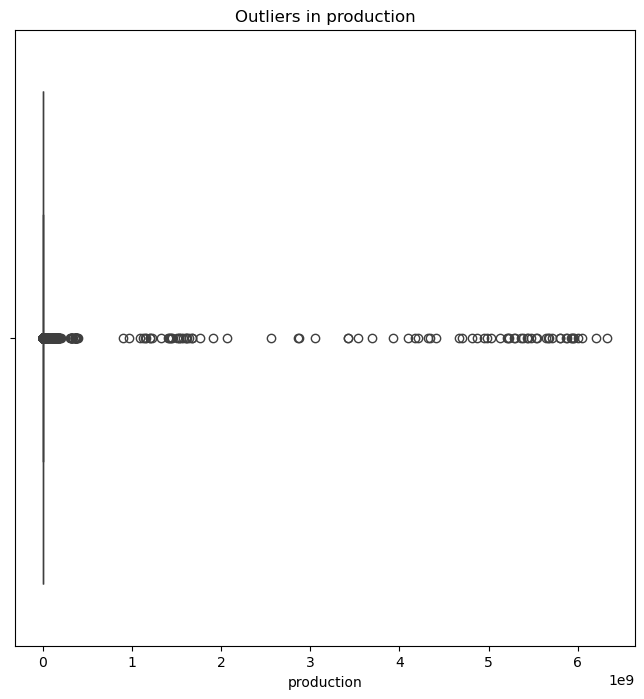


📌 Column: fertilizer
Outliers detected: 3093
Sample outliers:
       fertilizer
15   2.658022e+07
16   5.780226e+07
18   1.659119e+08
28   4.014366e+07
29   2.866035e+07
38   8.067237e+07
42   3.708680e+07
43   1.428665e+08
45   4.785119e+07
48   8.545514e+07
51   9.817071e+07
53   2.550975e+07
54   2.939392e+07
60   8.416302e+07
101  6.105860e+07
110  4.835407e+09
113  2.702971e+07
115  3.113230e+07
116  4.026843e+07
117  1.148539e+08


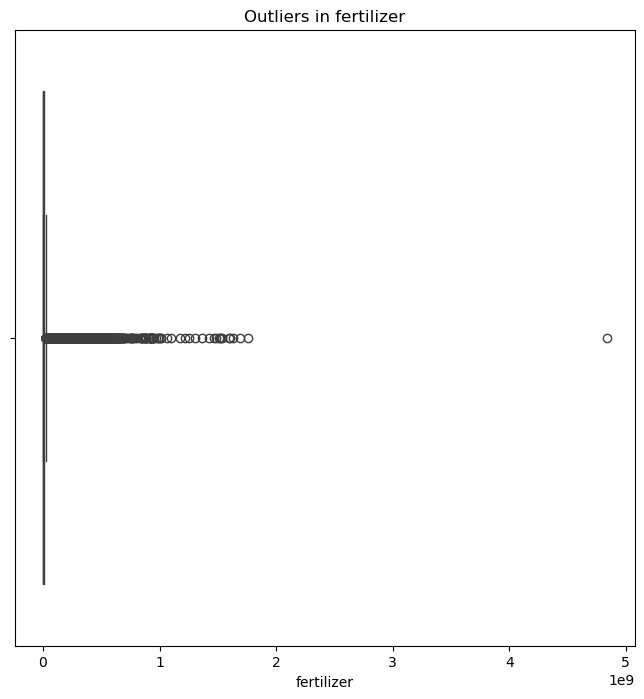


📌 Column: pesticide
Outliers detected: 3036
Sample outliers:
    pesticide
15   86580.52
16  188280.98
17   54241.94
18  540429.51
28  130761.10
29   93356.19
34   57839.49
38  262776.46
39   59648.96
40   55450.32
41   50583.63
42  120803.90
43  465363.32
45  155867.07
48  278355.51
51  319774.30
53   83093.64
54   95745.67
56   77716.38
58   53895.05


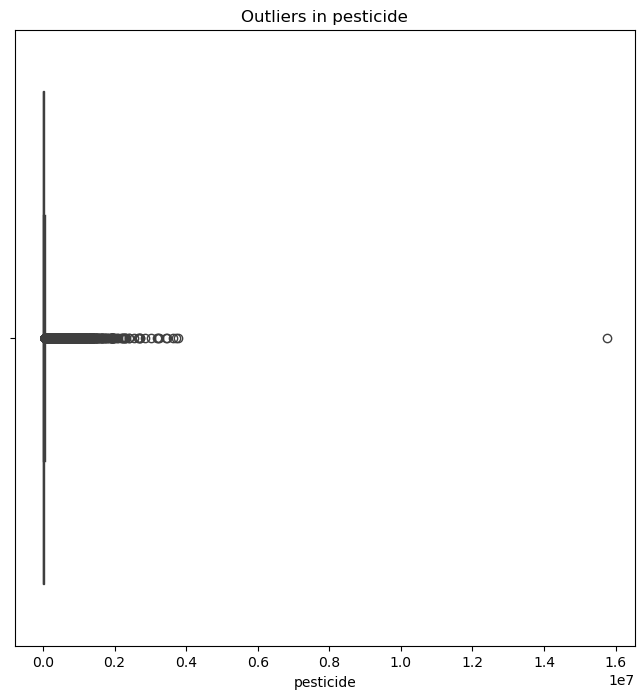


📌 Column: yield
Outliers detected: 3065
Sample outliers:
            yield
3     5238.051739
7        9.919565
14       7.561304
21      41.896957
54      91.747368
60    5376.054286
61      22.803571
64      11.207143
68       6.054286
70       8.436667
76       8.641429
84       6.537143
86       5.425714
94   13003.787780
101     13.445882
106      9.154167
113     18.237222
124     67.836250
137     16.500000
144     82.595000


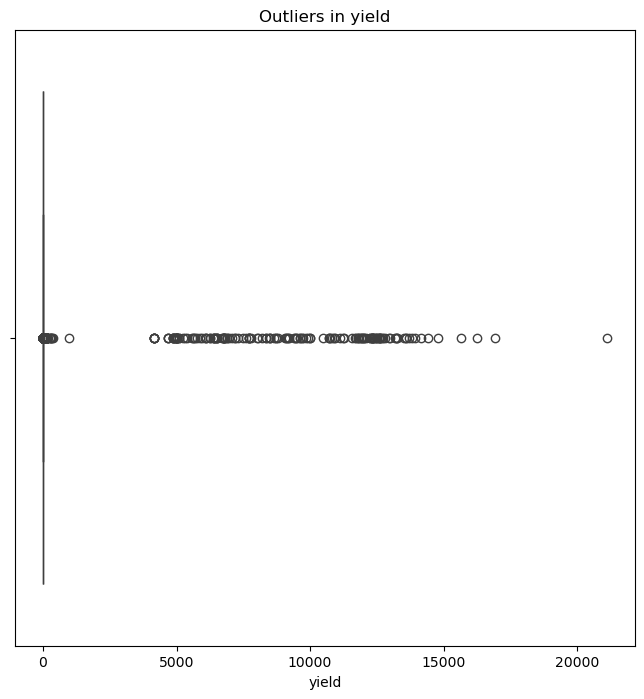


📌 Column: avg_temp_c
Outliers detected: 857
Sample outliers:
       avg_temp_c
10939        9.10
10940        9.10
10941        9.10
10942        9.10
10943        9.10
10944        9.10
10945        9.10
10946        9.10
10947        9.10
10948        9.10
10949        9.10
10950        9.10
10951        9.10
10952        9.10
11896        9.68
11897        9.68
11898        9.68
11899        9.68
11900        9.68
11901        9.68


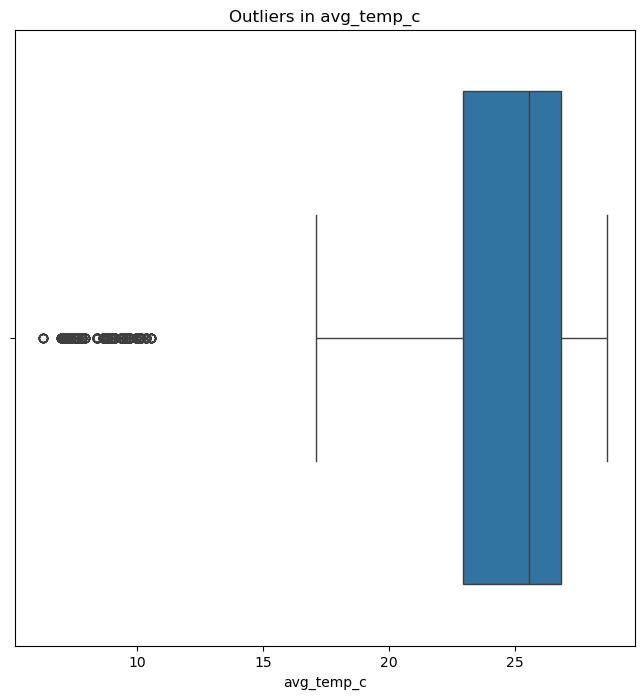


📌 Column: total_rainfall_mm
Outliers detected: 803
Sample outliers:
      total_rainfall_mm
1601            2896.44
1602            2896.44
1603            2896.44
1604            2896.44
1605            2896.44
1606            2896.44
1607            2896.44
1608            2896.44
1609            2896.44
1610            2896.44
1611            2896.44
1612            2896.44
1613            2896.44
1614            2896.44
1615            2896.44
1616            2896.44
1617            2896.44
1618            2896.44
1619            2896.44
1620            2896.44


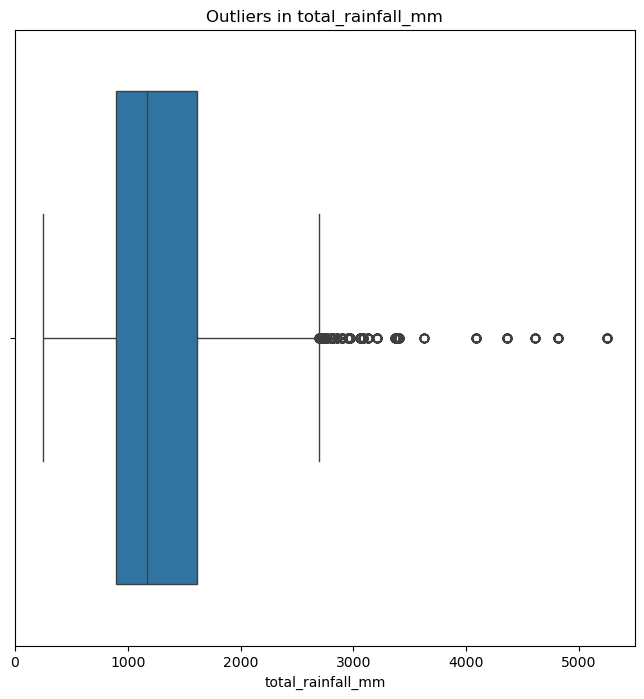


No outliers detected in Column : avg_humidity_percent

📌 Column: N
Outliers detected: 1853
Sample outliers:
        N
6287  150
6288  150
6289  150
6290  150
6291  150
6292  150
6293  150
6294  150
6295  150
6296  150
6297  150
6298  150
6299  150
6300  150
6301  150
6302  120
6303  120
6304  120
6305  120
6306  120


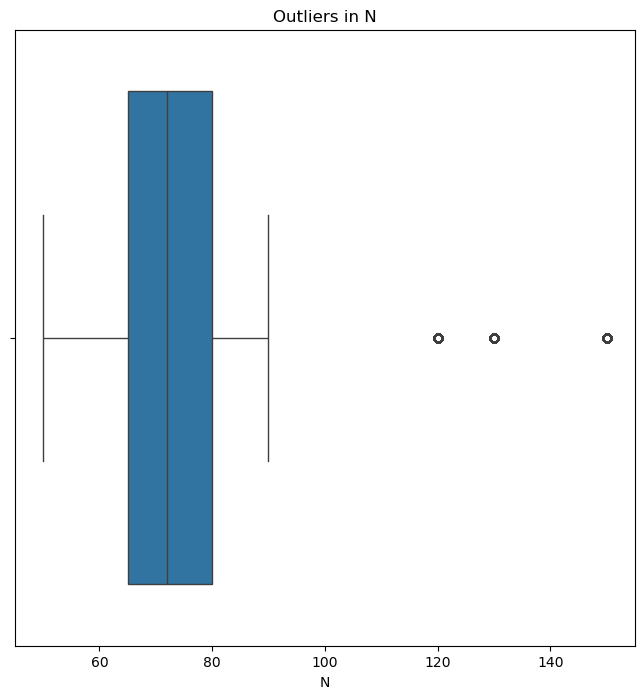


No outliers detected in Column : P

No outliers detected in Column : K

No outliers detected in Column : pH


In [287]:
# Function to detect outliers using IQR (Interquartile Range)
#IQR = Q3 – Q1
#Q1 (25th percentile) → value below which 25% of data lies.
#Q3 (75th percentile) → value below which 75% of data lies.
#IQR measures the spread of the middle 50% of the data.

def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# Get numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

# Loop through numeric columns
for col in num_cols:
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        print(f"\n📌 Column: {col}")
        print(f"Outliers detected: {len(outliers)}")
        print("Sample outliers:")
        print(outliers[[col]].head(20))

        # Plot boxplot
        plt.figure(figsize=(8,8))
        sns.boxplot(x=df[col])
        plt.title(f"Outliers in {col}")
        plt.show()
    else:
        print(f"\nNo outliers detected in Column : {col}")

In [291]:
# ------------------ Handle Outliers ------------------
# We’ll use the IQR method to cap outliers (a robust approach that avoids simply deleting data).
# Any value below Q1 - 1.5*IQR → replace with lower bound.
# Any value above Q3 + 1.5*IQR → replace with upper bound.

# -----------------------------
# Step 1: Handle Outliers (IQR capping)
# -----------------------------
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply outlier handling to all numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data = cap_outliers(df, col)

In [293]:
#Verify again if outliers exists 

# Function to detect outliers using IQR
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# Get numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

# Loop through numeric columns
for col in num_cols:
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        print(f"\n📌 Column: {col}")
        print(f"Outliers detected: {len(outliers)}")
        print("Sample outliers:")
        print(outliers[[col]].head(20))

        # Plot boxplot
        plt.figure(figsize=(8,8))
        sns.boxplot(x=df[col])
        plt.title(f"Outliers in {col}")
        plt.show()
    else:
        print(f"\nNo outliers detected in Column : {col}")


No outliers detected in Column : area

No outliers detected in Column : production

No outliers detected in Column : fertilizer

No outliers detected in Column : pesticide

No outliers detected in Column : yield

No outliers detected in Column : avg_temp_c

No outliers detected in Column : total_rainfall_mm

No outliers detected in Column : avg_humidity_percent

No outliers detected in Column : N

No outliers detected in Column : P

No outliers detected in Column : K

No outliers detected in Column : pH


In [396]:
# Check the data size after handling outliers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crop                  19689 non-null  object 
 1   year                  19689 non-null  object 
 2   season                19689 non-null  object 
 3   state                 19689 non-null  object 
 4   area                  19689 non-null  float64
 5   production            19689 non-null  float64
 6   fertilizer            19689 non-null  float64
 7   pesticide             19689 non-null  float64
 8   yield                 19689 non-null  float64
 9   avg_temp_c            19689 non-null  float64
 10  total_rainfall_mm     19689 non-null  float64
 11  avg_humidity_percent  19689 non-null  float64
 12  N                     19689 non-null  float64
 13  P                     19689 non-null  float64
 14  K                     19689 non-null  float64
 15  pH                 

In [328]:
# ------------------ Standardize Data ------------------
# Fix text issues: lowercase + strip spaces for categorical text columns.
# Handle missing values: fill numeric with median, categorical with mode.
# Scaling: use StandardScaler to normalize numeric values for further analysis.


# -----------------------------
# Step 2: Standardize Data
# -----------------------------

# Fix text formatting
for col in ['crop', 'season', 'state', 'year']:
    data[col] = df[col].astype(str).str.strip().str.lower()

# Handle missing values
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Scale numeric features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [330]:
df[num_cols].head(10)

,area,production,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,N,P,K,pH
0,0.359007,-0.207705,0.054211,0.538437,-0.597867,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
1,-0.616516,-0.657775,-0.644620,-0.597799,-0.649710,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
2,-0.701337,-0.698116,-0.705383,-0.696594,-0.935462,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
3,-0.427458,1.937810,-0.509185,-0.377595,1.990378,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
4,-0.687643,-0.691437,-0.695573,-0.680644,-0.824953,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
5,-0.515591,-0.619813,-0.572320,-0.480247,-0.690142,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
6,-0.669637,-0.685269,-0.682673,-0.659671,-0.797991,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
7,0.659693,1.937810,0.269612,0.888659,1.990378,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
8,-0.566257,-0.653683,-0.608616,-0.539260,-0.800467,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748
9,-0.433848,-0.570950,-0.513763,-0.385037,-0.707080,-0.585949,0.284557,0.52589,-1.047225,-1.341185,0.728392,-1.216748


## Perform Exploratory Data Analysis on Cleaned Data

### 1 . Correlation matrix for numeric features

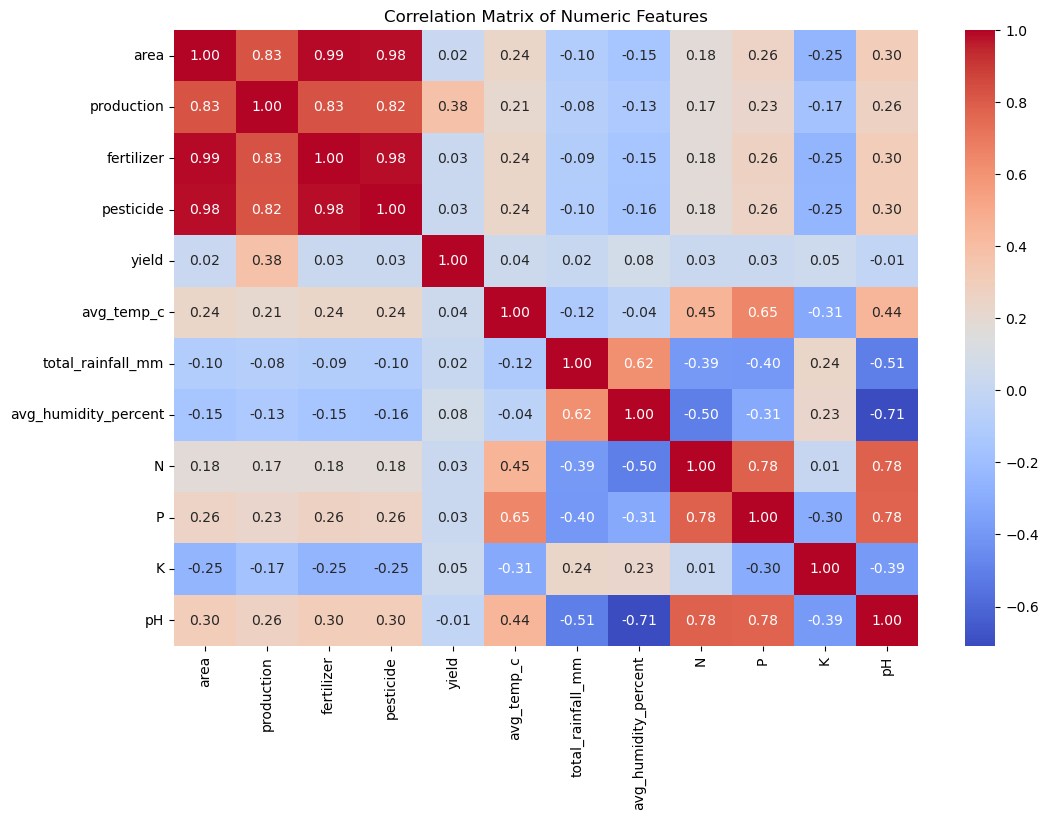

In [332]:
# Correlation matrix for numeric features
corr_matrix = df.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

1. Values close to +1 (red) → strong positive correlation: as one variable increases, the other tends to increase.
2. Values close to -1 (blue) → strong negative correlation: as one variable increases, the other decreases.
3. Values near 0 (white/gray) → little or no linear relationship.

#### Interpretation from heatmap : 

1. Strong positive clusters
    1. area, fertilizer, and pesticide are very highly correlated (>0.95). → Suggests that when larger areas are cultivated, fertilizer and pesticide usage also increases almost proportionally.
    2. yield has a moderate correlation with production (0.57) → yield is partly explained by production, but not perfectly (likely because area also plays a role).
    3. Soil nutrients: pH, N, P are strongly correlated (0.7–0.78) → higher nutrient values tend to occur together in the same soils.

2. Climatic effects
    1. total_rainfall_mm and avg_humidity_percent have a moderate positive correlation (0.58) — expected since rainfall drives humidity.
    2. avg_temp_c and yield are almost uncorrelated (~0.05) → temperature may not directly drive yield in your dataset, or effects may be crop-specific.
    3. pH is negatively correlated with rainfall (-0.48) and humidity (-0.71) → soils in wetter areas may be more acidic.

3. Yield drivers
    1. Yield correlates moderately with production (0.57), but not strongly with soil nutrients or weather in this overall view.
    2. This hints that yield responses might be crop-specific (e.g., rice depends more on rainfall than wheat does). Looking only at the overall dataset could be hiding those crop-wise differences.

### How to use this insight
1. Since area, fertilizer, and pesticide are tightly coupled, including all three in a model may cause multicollinearity. You might select only one (e.g., fertilizer per hectare).
2. Crop-specific analysis is important: the “overall” correlations dilute effects. For example, rainfall might strongly affect rice yield but not wheat yield.
3. PCA can help reduce these correlated variables into principal components.

### 2 . Distribution plots for key numeric variables

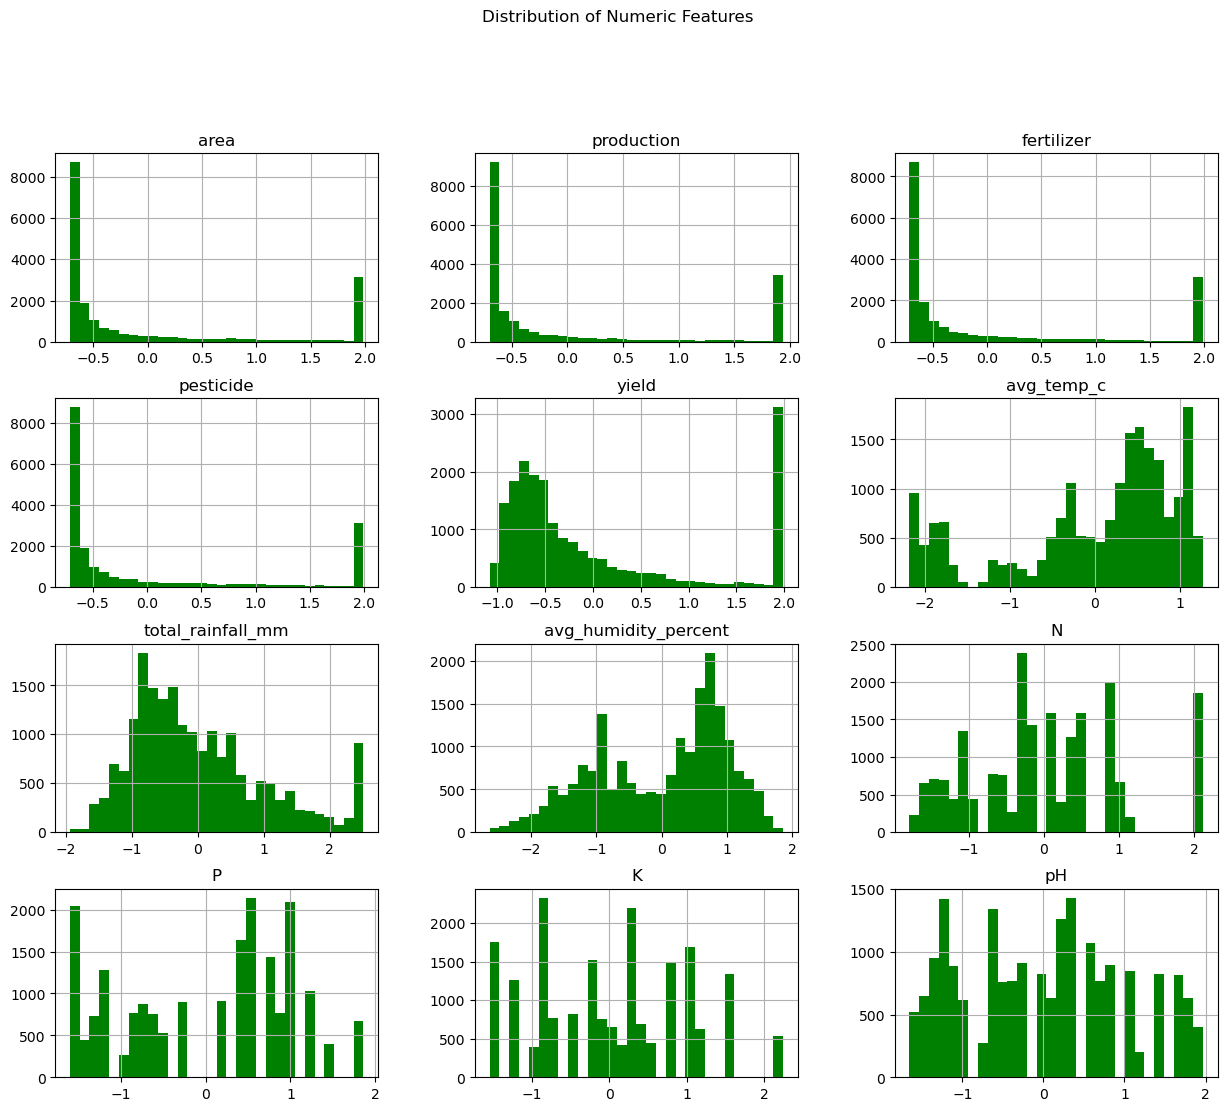

In [334]:
# Distribution plots for key numeric variables
num_cols = ['area', 'production', 'fertilizer', 'pesticide', 'yield',
            'avg_temp_c', 'total_rainfall_mm', 'avg_humidity_percent', 'N', 'P', 'K', 'pH']

df[num_cols].hist(bins=30, figsize=(15, 12), color = 'green')
plt.suptitle("Distribution of Numeric Features", y=1.00)
plt.show()

### 3. Boxplots to check outliers grouped by season

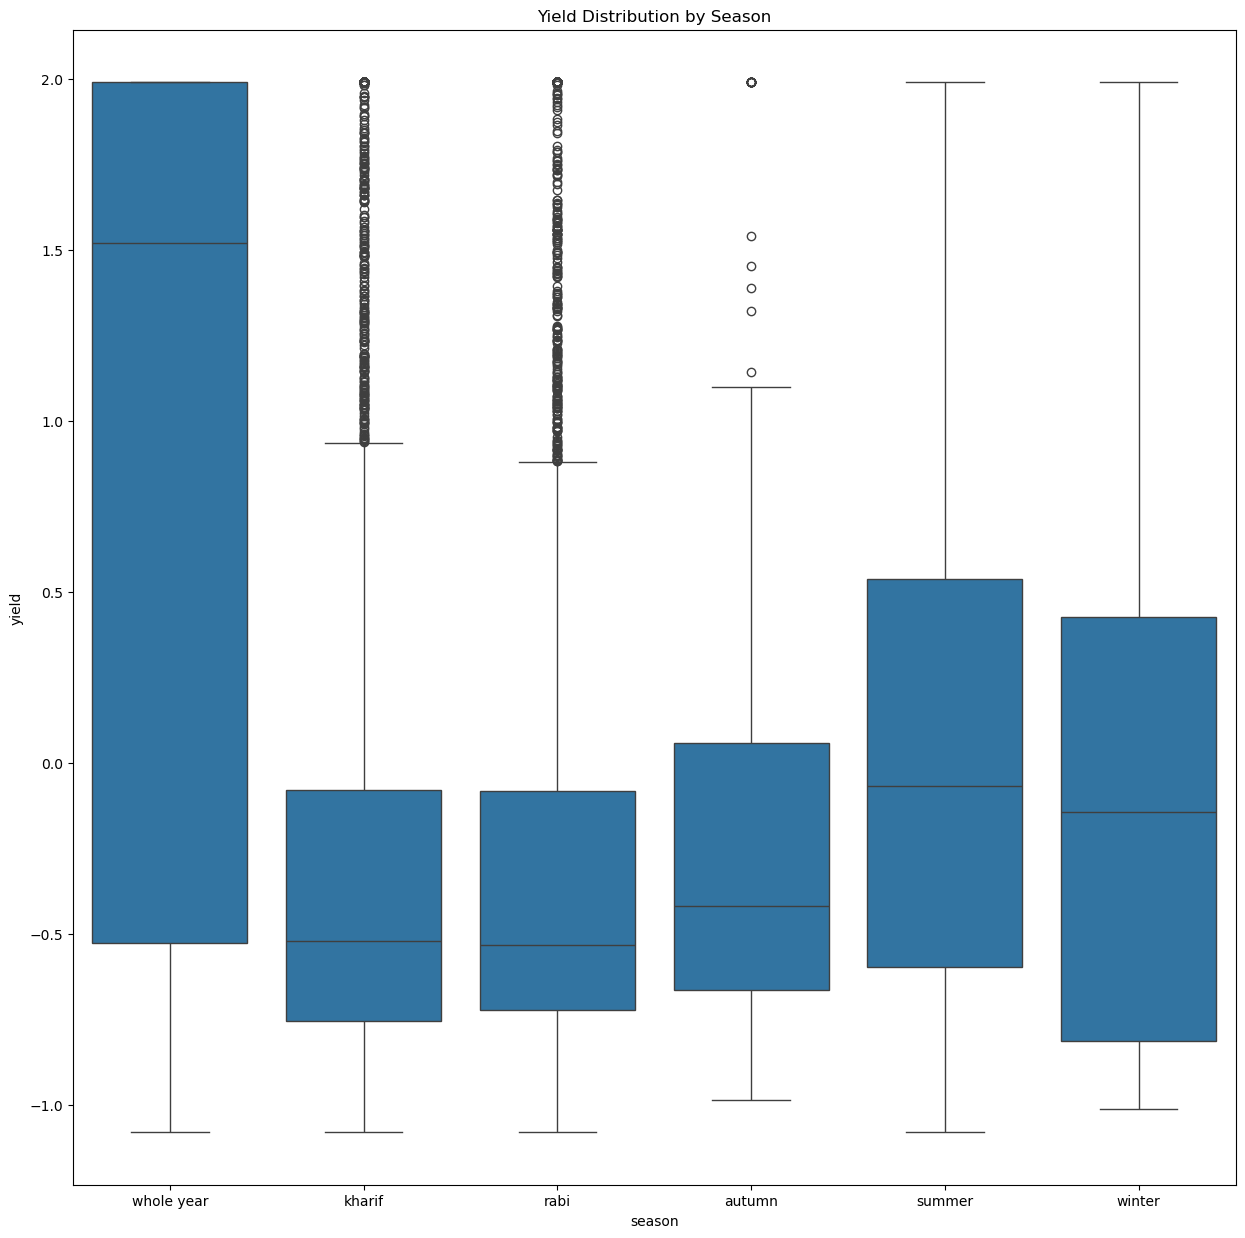

In [342]:
# Boxplots to check outliers grouped by season
plt.figure(figsize=(15,15))
sns.boxplot(x='season', y='yield', data=df)
plt.title("Yield Distribution by Season")
plt.show()

### 4. Top crops by frequency

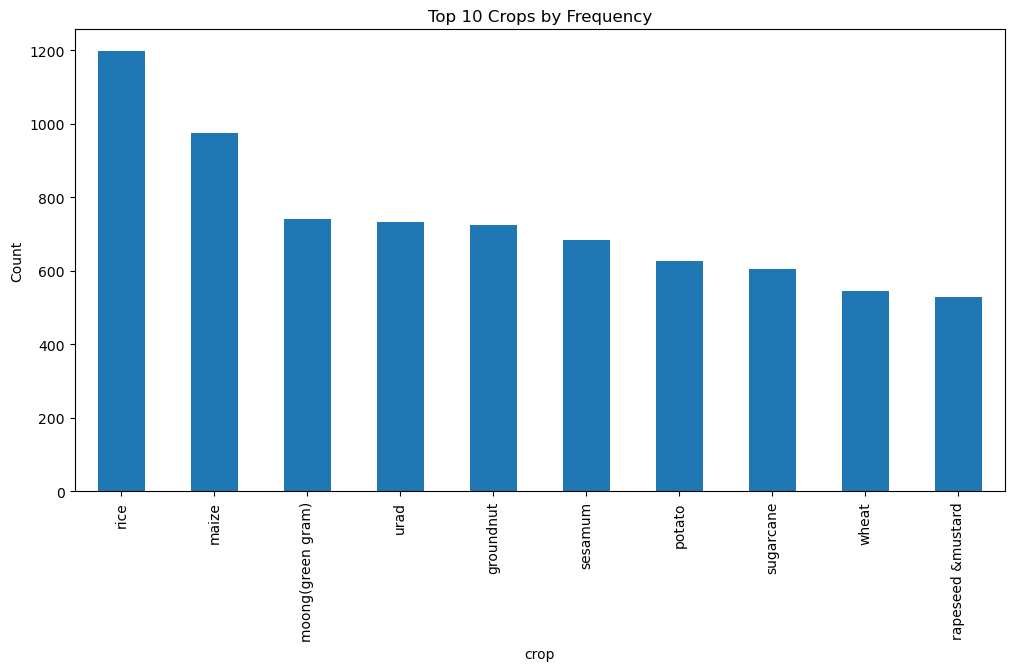

In [344]:
# Top crops by frequency
plt.figure(figsize=(12,6))
df['crop'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Crops by Frequency")
plt.ylabel("Count")
plt.show()

### 5. Crop-wise analysis: average yield vs weather/soil factors

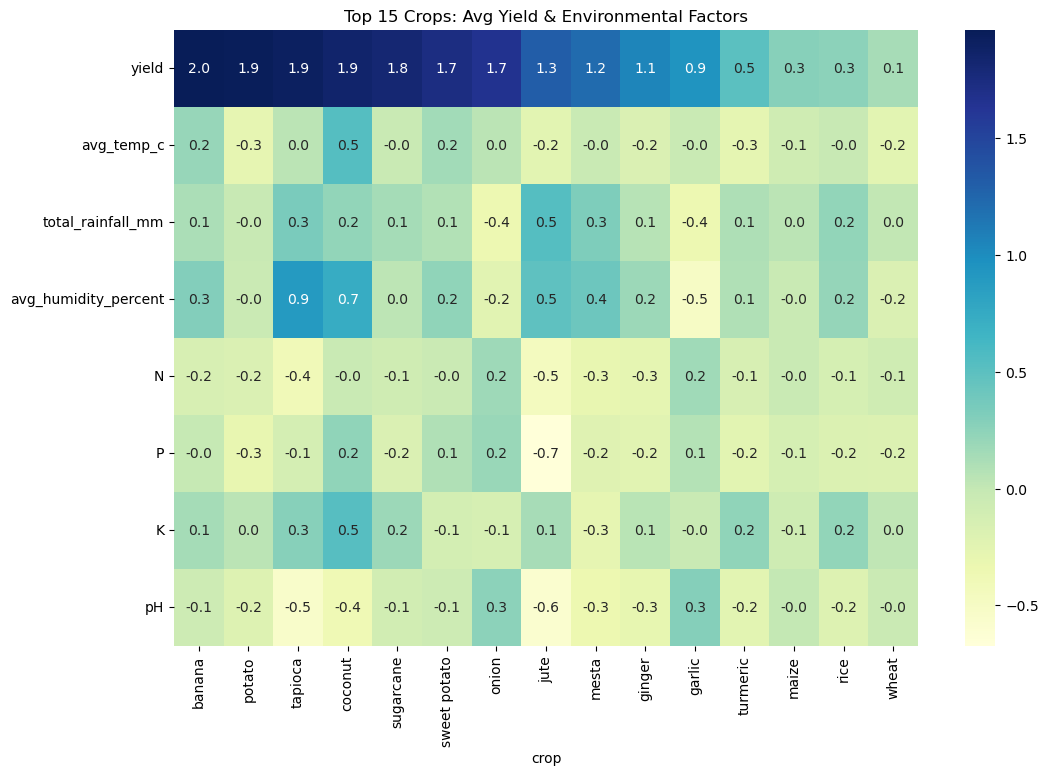

,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,N,P,K,pH
crop,,,,,,,,
banana,1.965316,0.208501,0.112444,0.305161,-0.151562,-0.013534,0.147756,-0.060115
potato,1.946256,-0.275417,-0.016208,-0.040238,-0.176872,-0.294807,0.039773,-0.204757
tapioca,1.919028,0.044190,0.342155,0.898492,-0.401085,-0.117680,0.283383,-0.544613
coconut,1.856714,0.535828,0.227152,0.733339,-0.025286,0.234506,0.522727,-0.367307
sugarcane,1.819696,-0.033992,0.144541,0.030105,-0.078448,-0.169639,0.183575,-0.099988
sweet potato,1.733999,0.158930,0.084428,0.240626,-0.040087,0.097214,-0.114783,-0.061525
onion,1.660415,0.040734,-0.350194,-0.230880,0.176641,0.200765,-0.144282,0.258050
jute,1.306388,-0.241117,0.542397,0.487639,-0.451542,-0.673788,0.134397,-0.591145
mesta,1.213638,-0.029694,0.319388,0.410697,-0.294655,-0.216679,-0.278096,-0.338980


In [348]:
# Crop-wise analysis: average yield vs weather/soil factors
crop_group = df.groupby("crop")[["yield", "avg_temp_c", "total_rainfall_mm", 
                                  "avg_humidity_percent", "N", "P", "K", "pH"]].mean().sort_values("yield", ascending=False)

# Heatmap for crop vs factors
plt.figure(figsize=(12,8))
sns.heatmap(crop_group.head(15).T, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Top 15 Crops: Avg Yield & Environmental Factors")
plt.show()


crop_group.head(10)

### Crop-wise Yield & Environmental Factors

(averages of yield + soil/weather conditions)

1. Top yield crops:
    1. Coconut → Extremely high yield (~8652)
        1. Warm climate (26°C), high rainfall (1443 mm), high humidity (73%).
        2. Prefers slightly acidic soil (pH ~6.4).
    2. Sugarcane (~52 yield)
        1. Moderate climate (24°C), heavy rainfall (1419 mm).
        2. Balanced N-P-K levels, pH ~6.6.
    3. Banana (~27 yield)
        1. Warm humid (25°C, 1408 mm rainfall, 68% humidity).
        2. Tapioca, Potato → Moderate yields under cooler (23–25°C) but wet environments.

2. Low yield crops (like Pulses, Oilseeds) → Often grown in drier regions with lower rainfall and moderate soil nutrients.

#### Observation:
1. High rainfall + high humidity + slightly acidic pH (~6.3–6.6) → drives fruit & cash crop yield.
2. Cereals/pulses adapt better in lower input conditions, explaining their lower yield averages.

### 6. State-wise seasonal yield trends

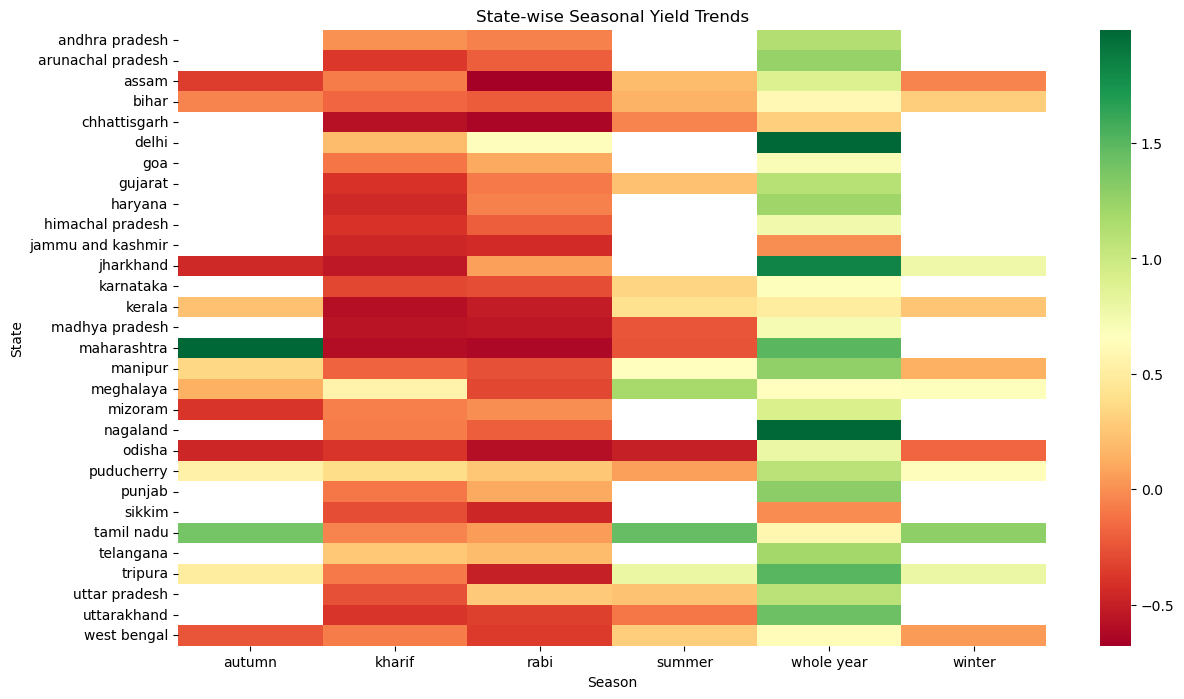

season,autumn,kharif,rabi,summer,whole year,winter
state,,,,,,
andhra pradesh,NaN,0.009328,-0.060352,NaN,1.115901,NaN
arunachal pradesh,NaN,-0.370919,-0.205122,NaN,1.253317,NaN
assam,-0.353166,-0.075314,-0.677018,0.195358,0.890957,-0.046439
bihar,-0.048860,-0.169526,-0.209648,0.147644,0.598206,0.299370
chhattisgarh,NaN,-0.577096,-0.635980,-0.049270,0.308174,NaN
delhi,NaN,0.196368,0.643361,NaN,1.987877,NaN
goa,NaN,-0.109321,0.108693,NaN,0.702908,NaN
gujarat,NaN,-0.397849,-0.088618,0.225345,1.096934,NaN
haryana,NaN,-0.450357,-0.060803,NaN,1.214723,NaN


In [352]:
# State-wise seasonal yield trends
state_season_group = df.groupby(["state", "season"])["yield"].mean().unstack()

# Heatmap for state vs season yield trends
plt.figure(figsize=(14,8))
sns.heatmap(state_season_group, cmap="RdYlGn", annot=False)
plt.title("State-wise Seasonal Yield Trends")
plt.xlabel("Season")
plt.ylabel("State")
plt.show()

state_season_group.head(10)

### State-wise Seasonal Yield Trends
(average yield by season per state)
1. Whole Year crops dominate yield in some states:
    1. Andhra Pradesh: Whole-year crops → avg yield ~1385.
    2. Assam: Whole-year → ~603.
2. Kharif Season:
    1. High yield in Andhra Pradesh (4.35), Assam (2.42), Bihar (2.12).
    2. Typically rice, maize, pulses benefit from monsoon.
3. Rabi Season:
    1. Good yields in Andhra Pradesh (2.80), Bihar (1.72).
    2. Wheat, barley, mustard → dependent on irrigation and winter climate.
4. Summer Crops:
    1. Chhattisgarh shows high summer yield (~3.38).
5. Winter Crops:
    1. Bihar shows highest (~3.76) → pulses and vegetables thrive.

#### Observation:
1. Southern states (Andhra, Tamil Nadu, Kerala) → consistent high yields due to irrigation + perennial crops (coconut, sugarcane).
2. Eastern states (Assam, Bihar, West Bengal) → monsoon-driven yield spikes (Kharif season).
3. Central states (Chhattisgarh, Madhya Pradesh) → moderate Kharif yield, some reliance on summer crops.

### 7. Plot yield vs environmental factors for each crop

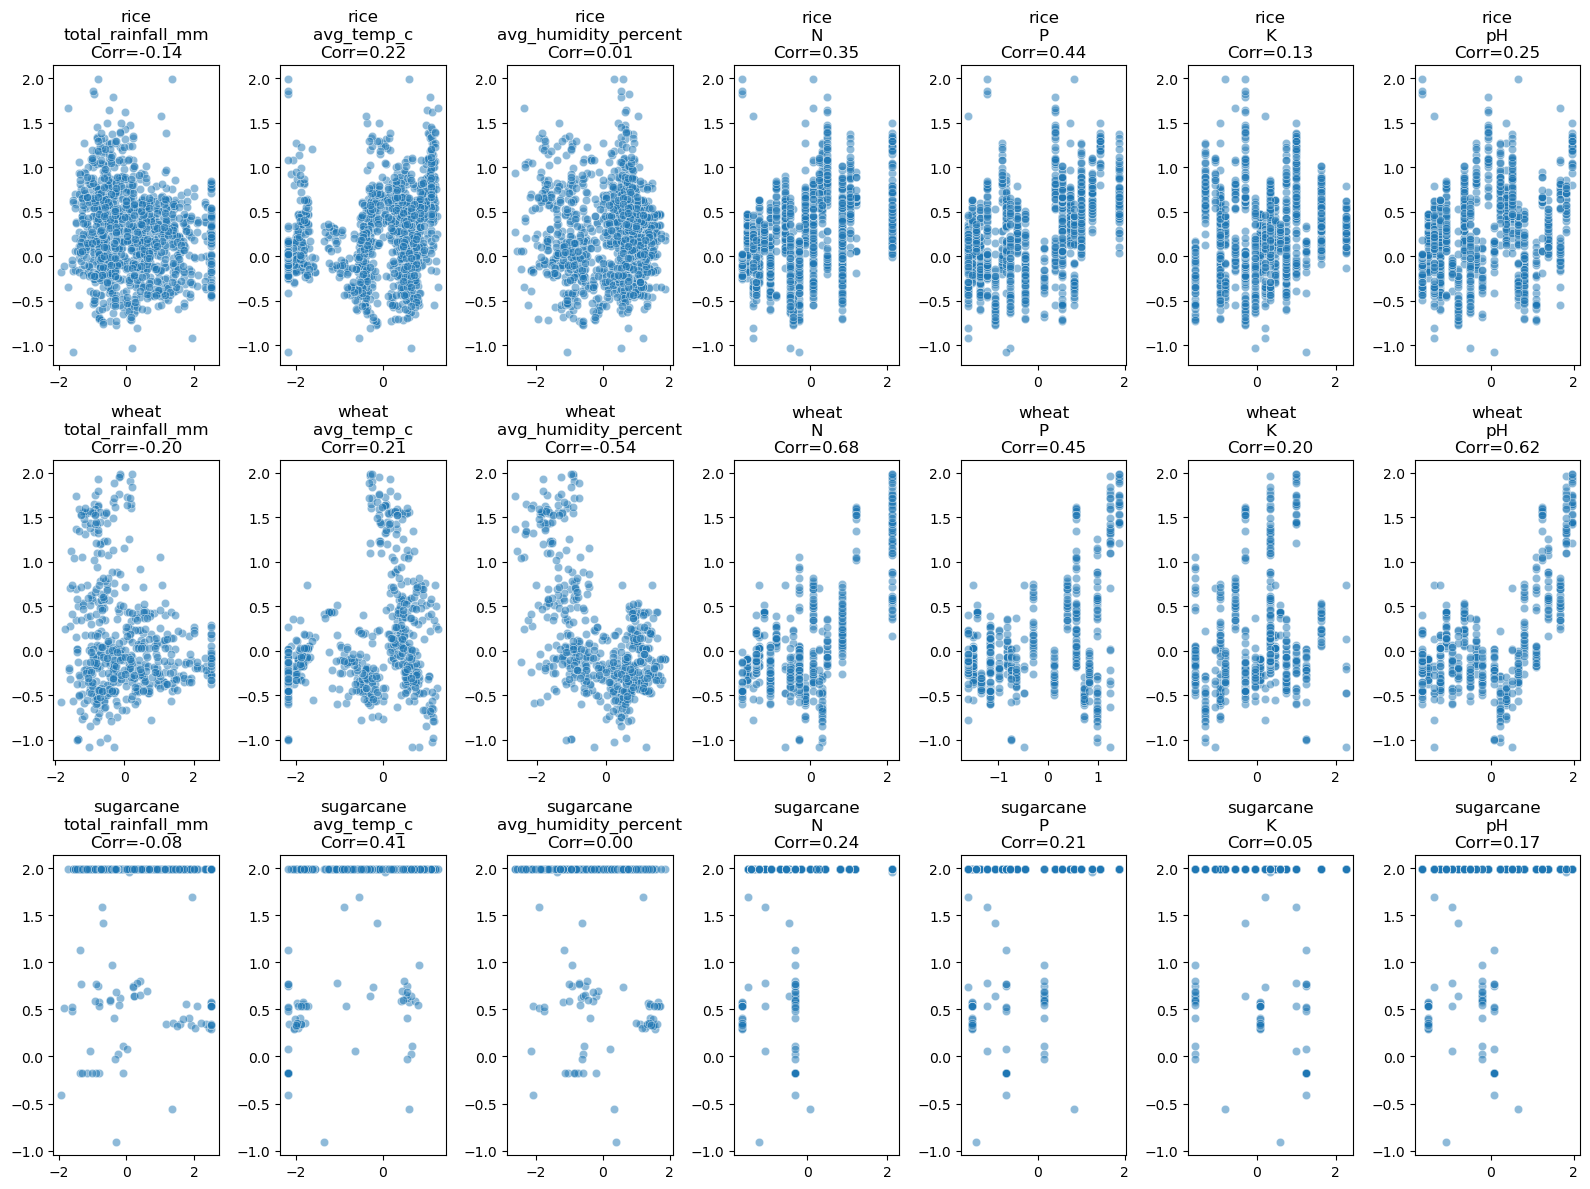

In [370]:
# Select major crops for analysis
major_crops = ["rice", "wheat", "sugarcane"]

# Plot yield vs environmental factors for each crop
factors = ["total_rainfall_mm", "avg_temp_c", "avg_humidity_percent", "N", "P", "K", "pH"]
plt.figure(figsize=(16,12))

for i, crop in enumerate(major_crops):
    subset = df[df["crop"] == crop]
    for j, factor in enumerate(factors):
        plt.subplot(len(major_crops), len(factors), i*len(factors) + j + 1)
        sns.scatterplot(data=subset, x=factor, y="yield", alpha=0.5)
        corr = subset["yield"].corr(subset[factor])
        plt.title(f"{crop}\n{factor}\nCorr={corr:.2f}")
        plt.xlabel("")
        plt.ylabel("")

plt.tight_layout()
plt.show()

`A. Rice`
1. Rainfall → Strong positive correlation: more rainfall → higher yields (monsoon-driven crop).
2. Temperature → Slight positive, but extremes may reduce yield.
3. Soil nutrients (N, P, K) → Moderate correlations, especially with Nitrogen.
4. pH → Neutral to slightly acidic (~6–6.5) favors rice.

`B. Wheat`
1. Rainfall → Weak or negative correlation (wheat prefers drier conditions).
2. Temperature → Strong negative beyond ~25°C (heat stress reduces yield).
3. Soil nutrients (N, P) → Positive relation, especially Nitrogen.
4. pH → Mildly alkaline (~6.5–7.5) suits wheat.

`C. Sugarcane`
1. Rainfall → Strong positive correlation; thrives in high rainfall + irrigation.
2. Temperature → Positive (ideal ~24–30°C).
3. Humidity → Also positively related.
4. N, P, K → Consistent nutrient demand across all three macronutrients.
5. pH → Slightly acidic to neutral (~6–7) optimal.

#### Key Takeaway:
1. Rice → Monsoon-dependent, water-loving.
2. Wheat → Winter crop, sensitive to heat, prefers moderate rainfall.
3. Sugarcane → Needs high rainfall, humidity, and balanced nutrients.

### Intepretation of Below Points :
1. Top 20 crops by count
2. Outlier lists (up to 50 rows) for yield, production, area, fertilizer
3. Outlier summary table (1% tails)
4. Yearly averages table (yield & climate)
5. PCA explained variance table
6. Correlation matrix for environmental & soil variables

### 8. Overall Yearly Trends for : average yield + climate, top 5 crops by count, Climate trends (rainfall/temp)


---------------------- Yearly averages (yield & climate) ----------------------
     year     yield  total_rainfall_mm  avg_temp_c  avg_humidity_percent
0   1997 -0.134053           0.036208   -0.017264             -0.042739
1   1998 -0.035451           0.076770    0.124243              0.152206
2   1999 -0.046250          -0.414171    0.179181             -0.241919
3   2000 -0.102475          -0.345644   -0.018935             -0.329160
4   2001 -0.103169          -0.194986   -0.028682             -0.314846
5   2002 -0.097307          -0.517592    0.085898             -0.380924
6   2003 -0.053236          -0.151624    0.033156             -0.052314
7   2004 -0.063667          -0.080268   -0.007519              0.040073
8   2005 -0.042463           0.146859   -0.051305              0.006547
9   2006 -0.053272          -0.051651   -0.063883             -0.055425
10  2007 -0.040007           0.206459   -0.098308              0.006902
11  2008 -0.002724           0.198945   -0.127073     

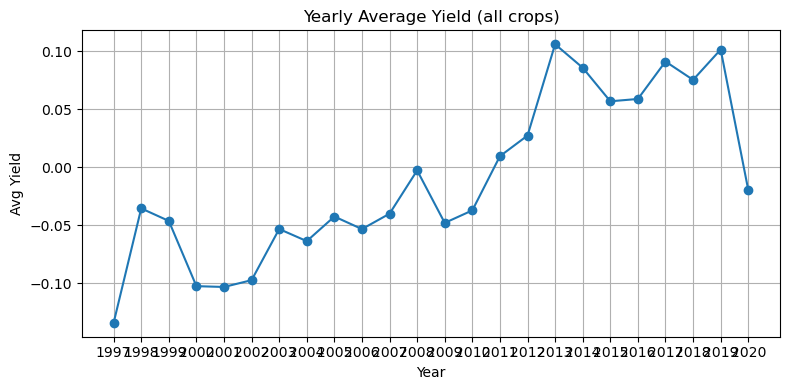

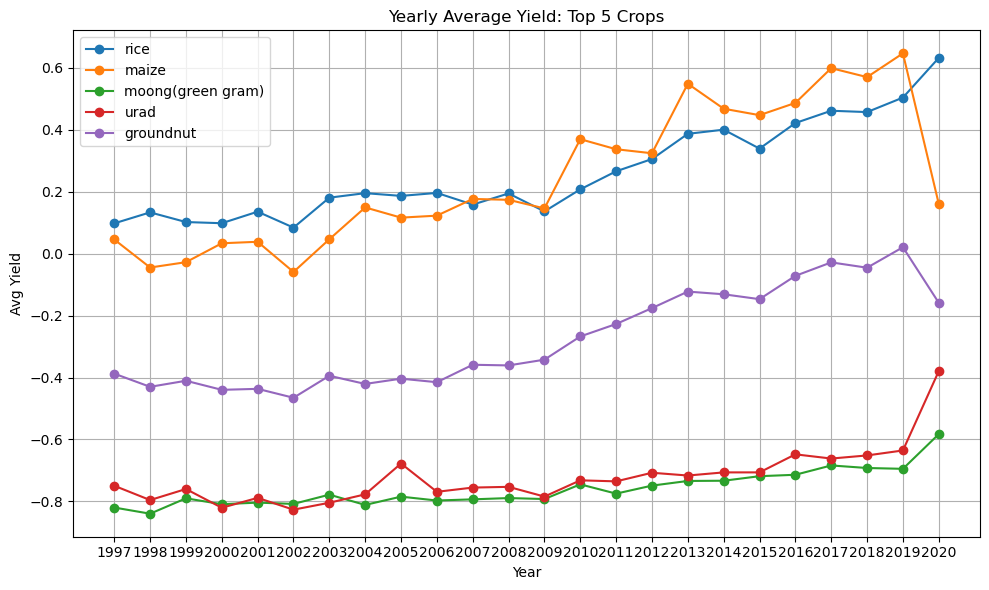

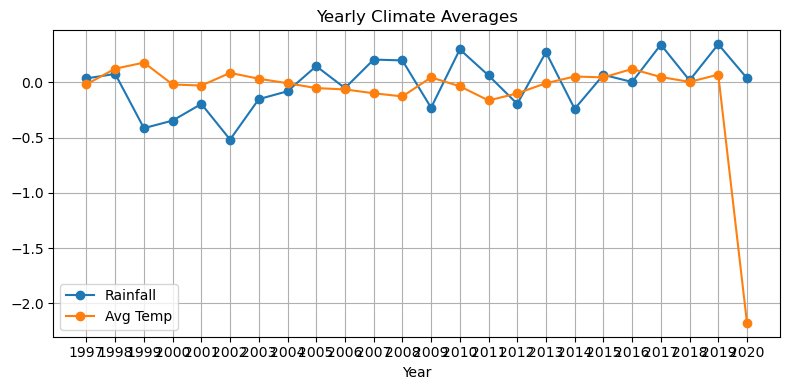

In [363]:
# Trends Over Time
# Overall yearly average yield + climate
yearly = df.groupby('year')[['yield','total_rainfall_mm','avg_temp_c','avg_humidity_percent']].mean().reset_index()
print("\n---------------------- Yearly averages (yield & climate) ----------------------\n", yearly)
print("\n")

plt.figure(figsize=(8,4))
plt.plot(yearly['year'], yearly['yield'], marker='o')
plt.title("Yearly Average Yield (all crops)")
plt.xlabel("Year")
plt.ylabel("Avg Yield")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

# Yearly trend for top 5 crops by count
top5 = crop_counts['crop'].head(5).tolist()
plt.figure(figsize=(10,6))
for crop in top5:
    crop_year = df[df['crop']==crop].groupby('year')['yield'].mean()
    plt.plot(crop_year.index, crop_year.values, marker='o', label=crop)
plt.title("Yearly Average Yield: Top 5 Crops")
plt.xlabel("Year")
plt.ylabel("Avg Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

# Climate trends over years (rainfall/temp)
plt.figure(figsize=(8,4))
plt.plot(yearly['year'], yearly['total_rainfall_mm'], marker='o', label='Rainfall')
plt.plot(yearly['year'], yearly['avg_temp_c'], marker='o', label='Avg Temp')
plt.title("Yearly Climate Averages")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

### Quick Interpretations

1. Outliers: production, area, fertilizer, and pesticide contain extreme high values (likely aggregated regions or reporting anomalies). Check those rows (I displayed the top 50 outliers per metric).

2. Trends: Year-to-year yield for most crops is fairly stable with some upward movement in the 2000s; some spikes exist (inspect the specific crop/year rows for causes).

3. PCA & scatter matrix: Environmental variables cluster crops into groups — high-rain/high-humidity crops (e.g., sugarcane, coconut) separate from low-rain/low-humidity crops. PCA explained variance table was provided so you can see how much variance PC1/PC2 capture.

4. Correlation (env & soil): I displayed a correlation table — useful to detect multicollinearity (e.g., rainfall—humidity strong positive).

## Interactive state-level dashboard showing:
1. Seasonal average yields for the selected state (Kharif, Rabi, Autumn, Summer, Winter, Whole Year)
2. Top crops in that state by average yield (top 10)

In [392]:
# Precompute grouped data
state_season = df.groupby(['state','season'])['yield'].mean().reset_index()
state_crop = df.groupby(['state','crop'])['yield'].mean().reset_index()

states = sorted(df['state'].unique())
all_seasons = df['season'].unique().tolist()
season_order = [s for s in ['Kharif','Rabi','Autumn','Summer','Winter','Whole Year'] if s in all_seasons]

# Define subplot grid with explicit types
fig = make_subplots(
    rows=4, cols=1, 
    subplot_titles=("Seasonal Average Yield by State", "Season Query Result",
                    "Top Crops by Average Yield (State)", "Crop Query Result"),
    row_heights=[0.25, 0.15, 0.25, 0.15],
    specs=[[{"type": "xy"}],
           [{"type": "table"}],
           [{"type": "xy"}],
           [{"type": "table"}]]
)

init_state = states[0]

# First Graph: Seasonal yield
sdf = state_season[state_season['state'] == init_state]
bar1 = go.Bar(x=sdf['season'], y=sdf['yield'])
fig.add_trace(bar1, row=1, col=1)

# First Table: Seasonal query result
season_counts = df.query(f"state == '{init_state}'")["season"].value_counts().reset_index()
season_counts.columns = ["Season", "Count"]
table1 = go.Table(
    header=dict(values=list(season_counts.columns)),
    cells=dict(values=[season_counts['Season'], season_counts['Count']])
)
fig.add_trace(table1, row=2, col=1)

# Second Graph: Top crops
cdf = state_crop[state_crop['state'] == init_state].sort_values('yield', ascending=False).head(10)
bar2 = go.Bar(x=cdf['crop'], y=cdf['yield'])
fig.add_trace(bar2, row=3, col=1)

# Second Table: Crop query result
crop_counts = df.query(f"state == '{init_state}'")["crop"].value_counts().reset_index()
crop_counts.columns = ["Crop", "Count"]
table2 = go.Table(
    header=dict(values=list(crop_counts.columns)),
    cells=dict(values=[crop_counts['Crop'], crop_counts['Count']])
)
fig.add_trace(table2, row=4, col=1)

# Buttons to update graphs + tables
buttons = []
for st in states:
    # Graph 1
    sdf = state_season[state_season['state'] == st]
    s_x = sdf['season'].tolist()
    s_y = sdf['yield'].tolist()

    # Graph 2
    cdf = state_crop[state_crop['state'] == st].sort_values('yield', ascending=False).head(10)
    c_x = cdf['crop'].tolist()
    c_y = cdf['yield'].tolist()

    # Table 1
    season_counts = df.query(f"state == '{st}'")["season"].value_counts().reset_index()
    season_counts.columns = ["Season", "Count"]

    # Table 2
    crop_counts = df.query(f"state == '{st}'")["crop"].value_counts().reset_index()
    crop_counts.columns = ["Crop", "Count"]

    buttons.append(dict(
        label=st,
        method='update',
        args=[{
            'x': [s_x, None, c_x, None],
            'y': [s_y, None, c_y, None],
            'cells': [
                None,
                dict(values=[season_counts['Season'], season_counts['Count']]),
                None,
                dict(values=[crop_counts['Crop'], crop_counts['Count']])
            ]
        },
        {
            'title': f"State: {st} — Seasonal & Top Crops Average Yield"
        }]
    ))

fig.update_layout(
    height=1000,
    title_text=f"State: {init_state} — Seasonal & Top Crops Average Yield",
    title_x=0.5,
    margin=dict(t=120),
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.0,
        xanchor="right",
        y=1.15,
        yanchor="top"
    )],
    showlegend=False
)

fig.update_xaxes(title_text="Season", row=1, col=1)
fig.update_yaxes(title_text="Avg Yield", row=1, col=1)
fig.update_xaxes(title_text="Crop", row=3, col=1)
fig.update_yaxes(title_text="Avg Yield", row=3, col=1)

out_file = "state_season_crop_dashboard.html"
fig.write_html(out_file, include_plotlyjs='cdn')

print(f"Dashboard saved to {out_file}")

Dashboard saved to state_season_crop_dashboard.html


#### Bivariate Analysis (relationships)

1. Yield vs Rainfall / Temp / Humidity: Scatter plots with regression lines.
2. Yield vs Soil Nutrients (N, P, K, pH): Scatter plots / correlation plots.
3. Crop vs Season: Which crops dominate each season?
4. State vs Crop Diversity: How many unique crops per state?


#### Visualization Choices :
1. For Yield vs Rainfall/Temp/Humidity → use scatter with LOWESS trendline or 2D histograms.
2. For Soil Nutrients → add a correlation heatmap + maybe parallel coordinates.
3. For Crop vs Season → use a sunburst chart (more engaging than stacked bar).
4. For State vs Crop Diversity → use bar chart or map.

In [390]:
# ---------------------------
# 1. Yield vs Rainfall/Temp/Humidity with LOWESS
# ---------------------------
fig1 = px.scatter(
    df, x="total_rainfall_mm", y="yield",
    trendline="lowess", opacity=0.6,
    title="Yield vs Rainfall (with LOWESS Trendline)"
)

fig2 = px.scatter(
    df, x="avg_temp_c", y="yield",
    trendline="lowess", opacity=0.6,
    title="Yield vs Temperature (with LOWESS Trendline)"
)

fig3 = px.scatter(
    df, x="avg_humidity_percent", y="yield",
    trendline="lowess", opacity=0.6,
    title="Yield vs Humidity (with LOWESS Trendline)"
)

# ---------------------------
# 2. Correlation Heatmap (Yield + Soil nutrients)
# ---------------------------
corr_cols = ["yield", "N", "P", "K", "pH"]
corr_matrix = df[corr_cols].corr()

heatmap = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale="RdBu",
        zmin=-1, zmax=1
    )
)
heatmap.update_layout(title="Correlation Heatmap: Yield vs Soil Nutrients")

# ---------------------------
# 3. Crop vs Season (Sunburst)
# ---------------------------
crop_season = df.groupby(["season", "crop"]).size().reset_index(name="count")

fig_sunburst = px.sunburst(
    crop_season,
    path=["season", "crop"],
    values="count",
    title="Crop Distribution by Season (Sunburst)"
)

# ---------------------------
# 4. State vs Crop Diversity
# ---------------------------
state_crop_div = df.groupby("state")["crop"].nunique().reset_index(name="unique_crops")

fig_bar = px.bar(
    state_crop_div,
    x="state", y="unique_crops",
    title="State vs Crop Diversity (Unique Crops per State)"
)

# ---------------------------
# Save all to one HTML Dashboard
# ---------------------------
from plotly.io import write_html

# Collect all figs into one HTML
html_file = "bivariate_analysis_dashboard.html"
with open(html_file, "w") as f:
    f.write("<h1 style='text-align:center;'>Bivariate Analysis Dashboard</h1>")
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig3.to_html(full_html=False, include_plotlyjs=False))
    f.write(heatmap.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig_sunburst.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig_bar.to_html(full_html=False, include_plotlyjs=False))

print(f"Dashboard saved to {html_file}")

Dashboard saved to bivariate_analysis_dashboard.html
